# Titanic Survival Prediction

## Data Dictionary
| Variable| Definition| Key                                             |
|---|---|-------------------------------------------------|
| survival| Survival| 0 = No, 1 = Yes                                 |
| pclass| Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd                       |
| sex| Sex                                                                |
| Age| Age in years                                                       |
| sibsp| # of siblings / spouses aboard the Titanic                         |
| parch| # of parents / children aboard the Titanic                         |
| ticket| Ticket number                                                      |
| fare| Passenger fare                                                     |
| cabin| Cabin number                                                       |
| embarked| Port of Embarkation| C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable Notes
**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
sns.set_theme(style="darkgrid", palette="dark")

## Exploratory Data Analysis (EDA)

### Reading Dataset
Data is from <https://www.kaggle.com/competitions/titanic/data>.

In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
test_df = pd.read_csv("test.csv")

### Viewing Data

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


### Data Dimensions

In [9]:
train_df.shape

(891, 12)

In [10]:
test_df.shape

(418, 11)

### Column Names

In [11]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Metadata

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Descriptive Statistics

In [15]:
object_columns = ["PassengerId", "Survived", "Pclass"]
dtype = {column: "object" for column in object_columns}
df = train_df.astype(dtype)

df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [16]:
df.describe(include="object")

,PassengerId,Survived,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891,891,204,889
unique,891,2,3,891,2,681,147,3
top,1,0,3,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,549,491,1,577,7,4,644


### Checking for Missing Values

In [17]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Checking for Duplicated Rows

In [18]:
train_df.duplicated().sum()

0

### Distribution of Survived

[Text(0, 0, '61.6% (549)'), Text(0, 0, '38.4% (342)')]

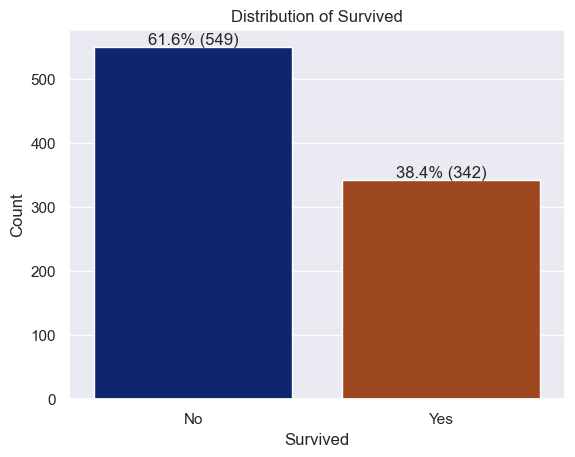

In [19]:
plot = sns.countplot(data=train_df, x="Survived")
title = "Distribution of Survived"
plot.set(
    ylabel="Count", xticklabels=["No", "Yes"], title=title
)
labels=[
    f"{v.get_height() / len(train_df):.1%}"
    f" ({v.get_height():.0f})"
    for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '63.0%'), Text(0, 0, '47.3%'), Text(0, 0, '24.2%')]

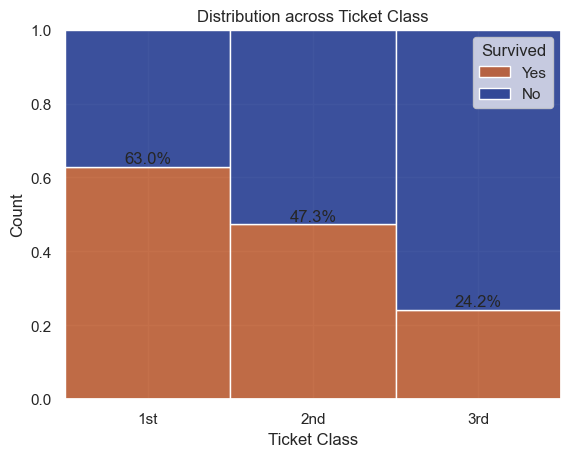

In [20]:
df = train_df.loc[:, ["Survived"]]
mappings = {1: "1st", 2: "2nd", 3: "3rd"}
df["Ticket Class"] = train_df.Pclass.map(mappings)
df.sort_values("Ticket Class", inplace=True)

x, hue = "Ticket Class", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")

plot.set_title("Distribution across Ticket Class")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '18.9%'), Text(0, 0, '74.2%')]

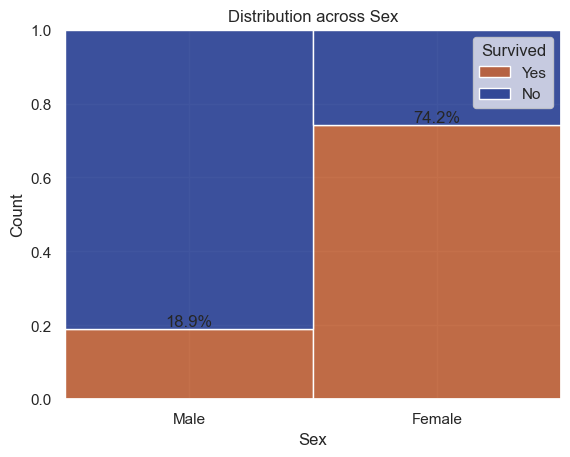

In [21]:
df = train_df.loc[:, ["Survived"]]
df["Sex"] = train_df.Sex.str.title()

x, hue = "Sex", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title("Distribution across Sex")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '34.5%'),
 Text(0, 0, '53.6%'),
 Text(0, 0, '46.4%'),
 Text(0, 0, '25.0%'),
 Text(0, 0, '16.7%'),
 Text(0, 0, '0.0%'),
 Text(0, 0, '0.0%')]

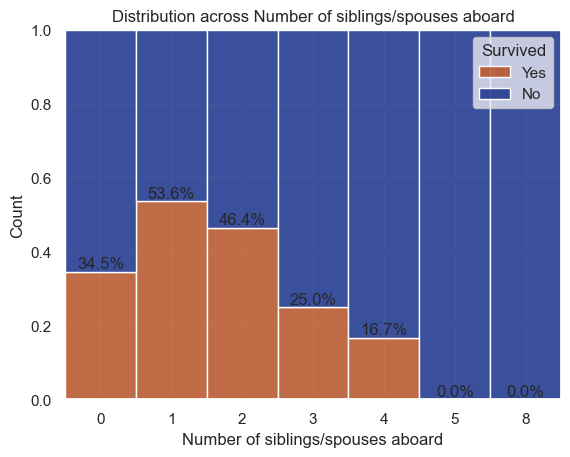

In [22]:
x, hue = "Number of siblings/spouses aboard", "Survived"
df = train_df.loc[:, ["Survived"]]
df[x] = train_df.SibSp.apply(str)
df.sort_values(x, inplace=True)

plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '34.4%'),
 Text(0, 0, '55.1%'),
 Text(0, 0, '50.0%'),
 Text(0, 0, '60.0%'),
 Text(0, 0, '0.0%'),
 Text(0, 0, '20.0%'),
 Text(0, 0, '0.0%')]

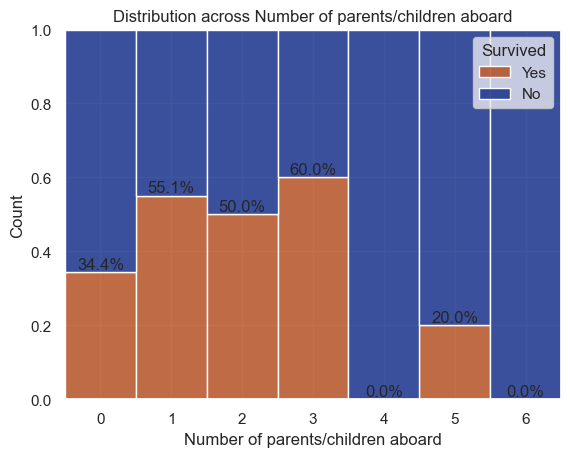

In [23]:
x, hue = "Number of parents/children aboard", "Survived"
df = train_df.loc[:, ["Survived"]]
df[x] = train_df.Parch.apply(str)
df.sort_values(x, inplace=True)

plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

[Text(0, 0, '55.4%'), Text(0, 0, '39.0%'), Text(0, 0, '33.7%')]

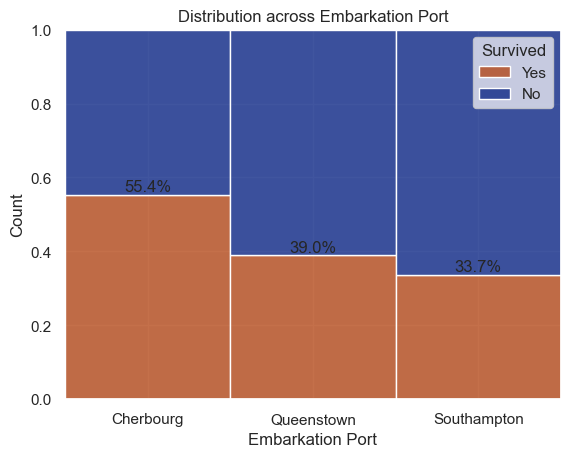

In [24]:
df = train_df.loc[:, ["Survived"]]
mappings = {
    "S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"
}
df["Embarkation Port"] = train_df.Embarked.map(mappings)
df.sort_values("Embarkation Port", inplace=True)

x, hue = "Embarkation Port", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")
plot.set_title("Distribution across Embarkation Port")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

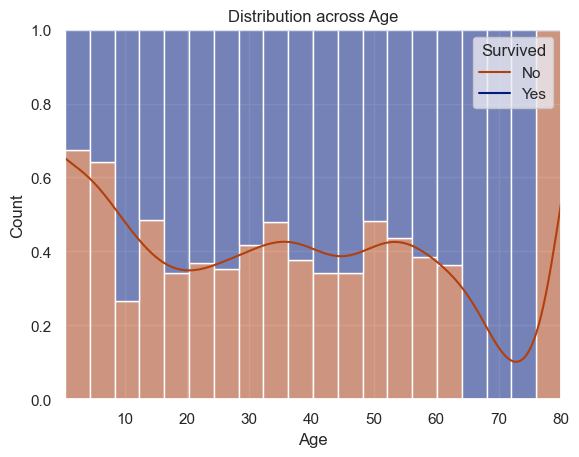

In [25]:
plot = sns.histplot(
    data=train_df, x="Age", hue="Survived",
    multiple="fill", kde=True
)
plot.set_title("Distribution across Age")
plot.legend(labels=["No", "Yes"], title="Survived")

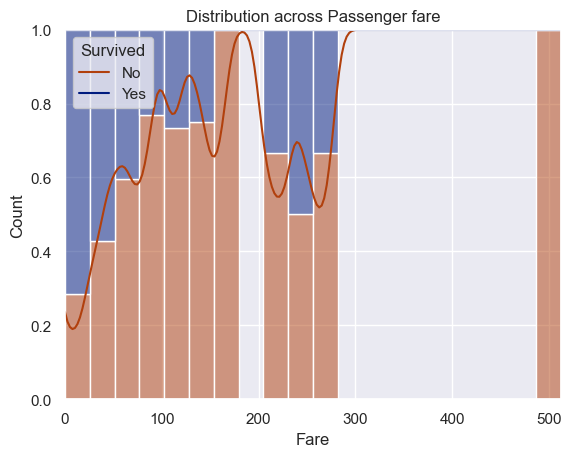

In [26]:
plot = sns.histplot(
    data=train_df, x="Fare", hue="Survived", bins=20,
    multiple="fill", kde=True
)
plot.set_title("Distribution across Passenger fare")
plot.legend(labels=["No", "Yes"], title="Survived")

## Data Pre-processing

### Feature Selection

In [27]:
columns = ["PassengerId", "Name", "Ticket", "Cabin"]
train_df_cleaned = train_df.drop(columns=columns)

train_df_cleaned.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [28]:
test_df_cleaned = test_df.drop(columns=columns)

test_df_cleaned.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

### Feature Extraction

In [29]:
honorifics = train_df.Name.str.extract(r"\s(\w+)\.")
train_df_cleaned["Honorific"] = honorifics

train_df_cleaned.Honorific

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Honorific, Length: 891, dtype: object

In [30]:
honorifics = test_df.Name.str.extract(r"\s(\w+)\.")
test_df_cleaned["Honorific"] = honorifics

test_df_cleaned["Honorific"]

0          Mr
1         Mrs
2          Mr
3          Mr
4         Mrs
        ...  
413        Mr
414      Dona
415        Mr
416        Mr
417    Master
Name: Honorific, Length: 418, dtype: object

In [31]:
df = train_df_cleaned.pivot_table(
    index="Honorific", columns="Sex",
    aggfunc="size", fill_value=0
)
df["total"] = df.female + df.male
df.sort_values("total", ascending=False)

Sex,female,male,total
Honorific,,,
Mr,0,517,517
Miss,182,0,182
Mrs,125,0,125
Master,0,40,40
Dr,1,6,7
Rev,0,6,6
Major,0,2,2
Col,0,2,2
Mlle,2,0,2


In [32]:
general_honorifics = ["Mr", "Miss", "Mrs", "Master"]

def generalise(row):
    return (
        row.Honorific
        if row.Honorific in general_honorifics
        else f"Other{row.Sex.title()}"
    )

df = train_df_cleaned[["Honorific", "Sex"]]
train_df_cleaned.Honorific = df.apply(generalise, axis=1)
train_df_cleaned.drop(columns="Sex", inplace=True)

train_df_cleaned.Honorific

0             Mr
1            Mrs
2           Miss
3            Mrs
4             Mr
         ...    
886    OtherMale
887         Miss
888         Miss
889           Mr
890           Mr
Name: Honorific, Length: 891, dtype: object

In [33]:
df = test_df_cleaned[["Honorific", "Sex"]]
test_df_cleaned.Honorific = df.apply(generalise, axis=1)
test_df_cleaned.drop(columns="Sex", inplace=True)

test_df_cleaned.Honorific

0               Mr
1              Mrs
2               Mr
3               Mr
4              Mrs
          ...     
413             Mr
414    OtherFemale
415             Mr
416             Mr
417         Master
Name: Honorific, Length: 418, dtype: object

[Text(0, 0, '15.7%'),
 Text(0, 0, '79.2%'),
 Text(0, 0, '69.8%'),
 Text(0, 0, '57.5%'),
 Text(0, 0, '25.0%'),
 Text(0, 0, '100.0%')]

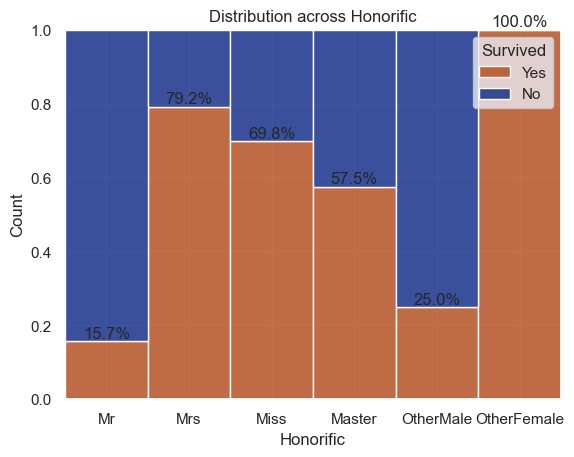

In [34]:
df, x, hue = train_df_cleaned, "Honorific", "Survived"
plot = sns.histplot(data=df, x=x, hue=hue, multiple="fill")

plot.set_title(f"Distribution across {x}")
plot.legend(labels=["Yes", "No"], title="Survived")

labels = [
    f"{v.get_height():.1%}" for v in plot.containers[0]
]
plot.bar_label(container=plot.containers[0], labels=labels)

### Replacing Missing Values

In [35]:
df = train_df_cleaned.groupby(["Honorific", "Pclass"])
series = df.Age.mean()

female = train_df.Sex == "female"
class_3 = train_df_cleaned.Pclass == 3
df = train_df_cleaned.loc[female & class_3]
series[("OtherFemale", 3)] = df.Age.mean()

series = round(series * 2) / 2
series.sort_index(inplace=True)

series

Honorific    Pclass
Master       1          5.5
             2          2.5
             3          5.5
Miss         1         30.0
             2         22.5
             3         16.0
Mr           1         41.5
             2         33.0
             3         28.5
Mrs          1         41.0
             2         33.5
             3         33.5
OtherFemale  1         33.5
             2         28.0
             3         22.0
OtherMale    1         48.5
             2         42.0
Name: Age, dtype: float64

In [36]:
def mean_age(row):
    return series[(row.Honorific, row.Pclass)]

age_series = train_df_cleaned.apply(mean_age, axis=1)
train_df_cleaned.Age.fillna(age_series, inplace=True)

train_df_cleaned.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    16.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [37]:
age_series = test_df_cleaned.apply(mean_age, axis=1)
test_df_cleaned.Age.fillna(age_series, inplace=True)

test_df_cleaned.Age

0      34.5
1      47.0
2      62.0
3      27.0
4      22.0
       ... 
413    28.5
414    39.0
415    38.5
416    28.5
417     5.5
Name: Age, Length: 418, dtype: float64

### One Hot Encoding

In [38]:
dtype = "int64"
one_hot_encoder = OneHotEncoder(sparse=False, dtype=dtype)

x = train_df_cleaned[["Honorific"]]
arrays = one_hot_encoder.fit_transform(x)
columns = one_hot_encoder.get_feature_names_out()

for column, row in zip(columns, arrays.T):
    if column != "Honorific_Mr":
        train_df_cleaned[column] = row

train_df_cleaned.drop(columns="Honorific", inplace=True)

column_bools = train_df_cleaned.columns.isin(columns)
train_df_cleaned.loc[:, column_bools]

,Honorific_Master,Honorific_Miss,Honorific_Mrs,Honorific_OtherFemale,Honorific_OtherMale
0,0,0,0,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,0,0
...,...,...,...,...,...
886,0,0,0,0,1
887,0,1,0,0,0
888,0,1,0,0,0
889,0,0,0,0,0


In [39]:
x = test_df_cleaned[["Honorific"]]
arrays = one_hot_encoder.transform(x)

for column, row in zip(columns, arrays.T):
    if column != "Honorific_Mr":
        test_df_cleaned[column] = row

test_df_cleaned.drop(columns="Honorific", inplace=True)

column_bools = test_df_cleaned.columns.isin(columns)
test_df_cleaned.loc[:, column_bools]

,Honorific_Master,Honorific_Miss,Honorific_Mrs,Honorific_OtherFemale,Honorific_OtherMale
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
413,0,0,0,0,0
414,0,0,0,1,0
415,0,0,0,0,0
416,0,0,0,0,0


In [40]:
dtype = "int64"
one_hot_encoder = OneHotEncoder(sparse=False, dtype=dtype)

x = train_df_cleaned[["Embarked"]]
arrays = one_hot_encoder.fit_transform(x)
columns = one_hot_encoder.get_feature_names_out()

for column, row in zip(columns, arrays.T):
    if column != "Embarked_S":
        train_df_cleaned[column] = row

train_df_cleaned.drop(columns="Embarked", inplace=True)

column_bools = train_df_cleaned.columns.isin(columns)
train_df_cleaned.loc[:, column_bools]

,Embarked_C,Embarked_Q,Embarked_nan
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
886,0,0,0
887,0,0,0
888,0,0,0
889,1,0,0


In [41]:
x = test_df_cleaned[["Embarked"]]
arrays = one_hot_encoder.transform(x)

for column, row in zip(columns, arrays.T):
    if column != "Embarked_S":
        test_df_cleaned[column] = row

test_df_cleaned.drop(columns="Embarked", inplace=True)

column_bools = test_df_cleaned.columns.isin(columns)
test_df_cleaned.loc[:, column_bools]

,Embarked_C,Embarked_Q,Embarked_nan
0,0,1,0
1,0,0,0
2,0,1,0
3,0,0,0
4,0,0,0
...,...,...,...
413,0,0,0
414,1,0,0
415,0,0,0
416,0,0,0


### Assigning x and y

In [43]:
x_train = train_df_cleaned.drop(columns="Survived")
y_train = train_df_cleaned.Survived
x_test = test_df_cleaned

print("Shape of training x:", x_train.shape)
print("Shape of training y:", y_train.shape)
print("Shape of testing x:", x_test.shape)

Shape of training x: (891, 13)
Shape of training y: (891,)
Shape of testing x: (418, 13)


### Standard Scaling

In [44]:
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)

x_train

array([[ 0.82737724, -0.5466093 ,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-1.56610693,  0.63439425,  0.43279337, ...,  2.0745051 ,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -0.25135841, -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       ...,
       [ 0.82737724, -0.98948563,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-1.56610693, -0.25135841, -0.4745452 , ...,  2.0745051 ,
        -0.30756234, -0.0474312 ],
       [ 0.82737724,  0.19151792, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ]])

In [45]:
x_test = scalar.transform(x_test)

x_test

array([[ 0.82737724,  0.37604972, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ],
       [ 0.82737724,  1.29870874,  0.43279337, ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [-0.36936484,  2.40589957, -0.4745452 , ..., -0.48204268,
         3.25137334, -0.0474312 ],
       ...,
       [ 0.82737724,  0.67130061, -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -0.06682661, -0.4745452 , ..., -0.48204268,
        -0.30756234, -0.0474312 ],
       [ 0.82737724, -1.76451921,  0.43279337, ...,  2.0745051 ,
        -0.30756234, -0.0474312 ]])

## EDA / Data Visualisation

### Variance Inflation Factor (VIF)

In [48]:
def calculate_vif(arrays):
    vif = Parallel(n_jobs=-1, verbose=5)(
        delayed(variance_inflation_factor)(arrays, index) for index in range(arrays.shape[1])
    )
    vif_series = pd.Series(vif)

    return vif_series.sort_values(ascending=False)


calculate_vif(x_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished


0     1.972959
1     1.832733
4     1.681259
5     1.497444
3     1.413352
6     1.409604
2     1.379024
7     1.224700
10    1.130069
11    1.122832
9     1.077300
8     1.034780
12    1.018192
dtype: float64

In [42]:
# def calculate_vif(df):
#     vif = Parallel(n_jobs=-1,verbose=5)(
#         delayed(variance_inflation_factor)(df.values, index) for index in range(df.shape[1])
#     )
#     vif_series = pd.Series(vif, index=df.columns)
#
#     return vif_series.sort_values(ascending=False)
#
#
# calculate_vif(train_df_cleaned.drop(columns=["Survived"]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  13 | elapsed:    5.6s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:    5.7s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    5.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    5.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    6.0s finished


Age                      4.723944
Pclass                   4.565846
Fare                     1.983212
Parch                    1.726863
SibSp                    1.689419
Honorific_Miss           1.527914
Honorific_Mrs            1.408300
Honorific_Master         1.394538
Embarked_C               1.369300
Embarked_Q               1.218316
Honorific_OtherMale      1.095240
Honorific_OtherFemale    1.023431
Embarked_nan             1.020257
dtype: float64

### Correlation

In [55]:
correlation_df = pd.DataFrame(x_train).corrwith(y_train)

correlation_df.abs().sort_values(ascending=False)

7     0.339040
0     0.338481
6     0.327093
4     0.257307
10    0.168240
8     0.112745
5     0.085221
3     0.081629
1     0.075797
12    0.060095
9     0.041703
2     0.035322
11    0.003650
dtype: float64

In [ ]:
# TODO: Visualise correlation